In [ ]:
!pip install ktrain

     |████████████████████████████████| 25.3MB 134kB/s 
     |████████████████████████████████| 6.8MB 47.6MB/s 
     |████████████████████████████████| 983kB 54.3MB/s 
     |████████████████████████████████| 266kB 55.5MB/s 
     |████████████████████████████████| 1.3MB 25.3MB/s 
     |████████████████████████████████| 1.2MB 55.9MB/s 
     |████████████████████████████████| 471kB 51.4MB/s 
     |████████████████████████████████| 2.9MB 54.5MB/s 
     |████████████████████████████████| 890kB 40.4MB/s 
  Created wheel for ktrain: filename=ktrain-0.25.3-cp36-none-any.whl size=25276312 sha256=9f78311168886336d422e2d359291be77b984a1c32673b84fcafe31bcf8d90ce
  Stored in directory: /root/.cache/pip/wheels/86/cd/9c/ad53b98a3eccf4ddeddccfce99d353781f206a1ac4287ca721
  Created wheel for langdetect: filename=langdetect-1.0.8-cp36-none-any.whl size=993194 sha256=5265fd431baf5a1c9c05d0ff427b1408904d1b4443922ea3f4191c891e95f75b
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d4

In [ ]:
import ktrain
from ktrain import text
import pandas as pd
import numpy as np
from sklearn.utils import shuffle, resample

## Load the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
news = pd.read_excel("/content/drive/MyDrive/Masterarbeit/Crawler/data/FinalDataset/Ablation01/CleanData_FinalDataset_ForModel_Ablation1.xlsx", index_col=0)

In [ ]:
# Get the same train and test data
def split_df_in_train_test(df):
    df = df.reset_index()
    split_point = int(np.round(df.shape[0]) * 0.8)
    df_train = df.loc[:split_point-1,:]
    df_test = df.loc[split_point:,:]
    return df_train, df_test

In [ ]:
n_samples = 6000

In [ ]:
left_FE = resample(shuffle(news[(news["label"]=="links") & (news.maintext.str.split().str.len()<512)], random_state=42), \
         random_state=42, n_samples=n_samples)
center_FE = resample(shuffle(news[(news["label"]=="central") & (news.maintext.str.split().str.len()<512)], random_state=42), \
         random_state=42, n_samples=n_samples)
right_FE = resample(shuffle(news[(news["label"]=="rechts") & (news.maintext.str.split().str.len()<512)], random_state=42), \
         random_state=42, n_samples=n_samples)

In [ ]:
train = pd.concat([split_df_in_train_test(left_FE)[0], \
    split_df_in_train_test(center_FE)[0], \
    split_df_in_train_test(right_FE)[0]])

In [ ]:
test =  pd.concat([split_df_in_train_test(left_FE)[1], \
    split_df_in_train_test(center_FE)[1], \
    split_df_in_train_test(right_FE)[1]])

In [ ]:
x_train = train["maintext"].to_list()
y_train = train["label"].to_list()
x_test = test["maintext"].to_list()
y_test = test["label"].to_list()

In [ ]:
class_names = list(train["label"].unique())

## Build the model

In [ ]:
model_name = "bert-base-german-cased"

In [ ]:
t = text.Transformer(model_name, maxlen=512, classes= class_names)

/usr/local/lib/python3.6/dist-packages/ktrain/text/preprocessor.py:414: UserWarning: The class_names argument is replacing the classes argument. Please update your code.
  warnings.warn('The class_names argument is replacing the classes argument. Please update your code.')


In [ ]:
trn = t.preprocess_train(x_train, y_train)
val = t.preprocess_test(x_test, y_test)

preprocessing train...
language: de
train sequence lengths:
	mean : 224
	95percentile : 471
	99percentile : 503


/usr/local/lib/python3.6/dist-packages/ktrain/utils.py:589: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


Is Multi-Label? False
preprocessing test...
language: de
test sequence lengths:
	mean : 222
	95percentile : 471
	99percentile : 504


In [ ]:
trn.x

array([[[    3, 10311,  3405, ...,     0,     0,     0],
        [    1,     1,     1, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]],

       [[    3,     2,   655, ...,   130, 26921,     4],
        [    1,     1,     1, ...,     1,     1,     1],
        [    0,     0,     0, ...,     0,     0,     0]],

       [[    3,  5310, 26897, ..., 26916, 26914,     4],
        [    1,     1,     1, ...,     1,     1,     1],
        [    0,     0,     0, ...,     0,     0,     0]],

       ...,

       [[    3, 17095,  1923, ...,    42,  3361,     4],
        [    1,     1,     1, ...,     1,     1,     1],
        [    0,     0,     0, ...,     0,     0,     0]],

       [[    3, 11813,   292, ...,     0,     0,     0],
        [    1,     1,     1, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]],

       [[    3, 25020,  2973, ...,     0,     0,     0],
        [    1,     1,     1, ...,     0,     0,     0],
        

In [ ]:
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=8)

In [ ]:
model.loss

In [ ]:
learner.freeze()

simulating training for different learning rates... this may take a few moments...
1800/1800 [==============================] - 626s 340ms/step - loss: 1.8653 - accuracy: 0.3655


done.
Visually inspect loss plot and select learning rate associated with falling loss


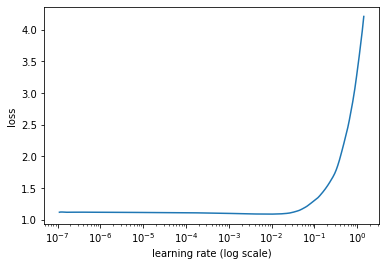

In [ ]:
learner.lr_find(show_plot=True, max_epochs=1)

In [ ]:
optimal_lr = learner.lr_estimate()[1]

In [ ]:
print(optimal_lr)

0.0009120099246501922


In [ ]:
learner.fit(0.00001, 7)

Epoch 1/7
1800/1800 [==============================] - 1939s 1s/step - loss: 0.7580 - accuracy: 0.6474 - val_loss: 0.3605 - val_accuracy: 0.8572
Epoch 2/7
1800/1800 [==============================] - 1924s 1s/step - loss: 0.2813 - accuracy: 0.8978 - val_loss: 0.2728 - val_accuracy: 0.8939
Epoch 3/7
1800/1800 [==============================] - 1924s 1s/step - loss: 0.1308 - accuracy: 0.9562 - val_loss: 0.2522 - val_accuracy: 0.9147
Epoch 4/7
1800/1800 [==============================] - 1925s 1s/step - loss: 0.0621 - accuracy: 0.9789 - val_loss: 0.3345 - val_accuracy: 0.9067
Epoch 5/7
1800/1800 [==============================] - 1925s 1s/step - loss: 0.0375 - accuracy: 0.9876 - val_loss: 0.3718 - val_accuracy: 0.9050
Epoch 6/7
1800/1800 [==============================] - 1925s 1s/step - loss: 0.0265 - accuracy: 0.9920 - val_loss: 0.4343 - val_accuracy: 0.8950
Epoch 7/7
1800/1800 [==============================] - 1924s 1s/step - loss: 0.0271 - accuracy: 0.9912 - val_loss: 0.3882 - val_ac

In [ ]:
learner.validate(class_names=class_names)

              precision    recall  f1-score   support

       links       0.92      0.92      0.92      1200
     central       0.90      0.92      0.91      1200
      rechts       0.91      0.88      0.89      1200

    accuracy                           0.91      3600
   macro avg       0.91      0.91      0.91      3600
weighted avg       0.91      0.91      0.91      3600



array([[1107,   41,   52],
       [  34, 1109,   57],
       [  64,   77, 1059]])